In [1]:
%matplotlib inline
import cv2, os, math, time, ast
from tqdm import tqdm
from datetime import datetime
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from typing import List
from torchvision.ops import box_iou
from matplotlib.image import imread
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchvision.models.detection import retinanet_resnet50_fpn_v2, RetinaNet_ResNet50_FPN_V2_Weights
from torchinfo import summary

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#% cd /content/gdrive/MyDrive/datasets/gbr_cots/
%cd ..
cwd = os.getcwd()

h:\Python\ob\train_models


In [3]:
base_dir = 'h:\Python\ob'
train_csv = os.path.join(base_dir, "train.csv")
train_df = pd.read_csv(train_csv)
train_df["img_path"] = os.path.join(base_dir, "train_images") + "/video_" + train_df.video_id.astype(str) + "/" + train_df.video_frame.astype(str) + ".jpg"
train_df["annotations"] = train_df["annotations"].apply(eval)
train_df["a_count"] = train_df["annotations"].apply(len)
train_df = train_df.drop(columns=['video_id', 'sequence', 'video_frame', 'sequence_frame'])
train_df_positive = train_df[train_df['a_count'] != 0]
train_df_positive= train_df_positive.reset_index(drop=True)
print('shape of train data with annotations:', train_df_positive.shape)

train_df_ratio = (train_df_positive.set_index('image_id').explode('annotations').
                  apply(lambda row: pd.Series(row['annotations']), axis=1).reset_index())
train_df_ratio['aspect_ratio'] = train_df_ratio['height']/train_df_ratio['width']
train_df_ratio['area_ratio'] = train_df_ratio['height'] * train_df_ratio['width']/(1280 * 720)


train_df_p, val_df_p = train_test_split(train_df_positive, test_size=0.1, random_state=0)
print('shape of training data:', train_df_p.shape)
print('shape of validation data:', val_df_p.shape)
print('Min number of bboxs per image:', min(train_df_positive.a_count))
print('Max number of bboxs per image:', max(train_df_positive.a_count))
print('Max width of all bboxs:', max(train_df_ratio.width))
print('Max height of all bboxs:', max(train_df_ratio.height))
print('Min width of all bboxs:', min(train_df_ratio.width))
print('Min height of all bboxs:', min(train_df_ratio.height))

print('{:.2%} of all aspect ratios greater than 2'.
      format(train_df_ratio[train_df_ratio['aspect_ratio'] > 1.5].shape[0]/train_df_ratio.shape[0]))

print('{:.2%} of all aspect ratios less than 0.25'.
      format(train_df_ratio[train_df_ratio['aspect_ratio'] < 0.5].shape[0]/train_df_ratio.shape[0]))

shape of train data with annotations: (4919, 4)
shape of training data: (4427, 4)
shape of validation data: (492, 4)
Min number of bboxs per image: 1
Max number of bboxs per image: 18
Max width of all bboxs: 243
Max height of all bboxs: 222
Min width of all bboxs: 17
Min height of all bboxs: 13
1.47% of all aspect ratios greater than 2
1.15% of all aspect ratios less than 0.25


In [4]:
# EDA summary statistics 
df01 = train_df_ratio.describe().applymap('{:,.3f}'.format)
df02 = pd.DataFrame(train_df_positive["a_count"]).describe().applymap('{:,.3f}'.format)
df01['annotations_per_image'] = df02['a_count']
print(df01.to_latex(index=True))

\begin{tabular}{llllllll}
\toprule
{} &           x &           y &       width &      height & aspect\_ratio &  area\_ratio & annotations\_per\_image \\
\midrule
count &  11,898.000 &  11,898.000 &  11,898.000 &  11,898.000 &   11,898.000 &  11,898.000 &             4,919.000 \\
mean  &     490.039 &     346.268 &      47.885 &      42.723 &        0.915 &       0.002 &                 2.419 \\
std   &     274.052 &     185.139 &      17.449 &      15.379 &        0.207 &       0.002 &                 2.862 \\
min   &       0.000 &       0.000 &      17.000 &      13.000 &        0.216 &       0.000 &                 1.000 \\
25\%   &     278.000 &     198.000 &      35.000 &      32.000 &        0.795 &       0.001 &                 1.000 \\
50\%   &     477.000 &     346.000 &      45.000 &      40.000 &        0.902 &       0.002 &                 1.000 \\
75\%   &     664.000 &     493.750 &      57.000 &      52.000 &        1.015 &       0.003 &                 2.000 \\
max   & 

C:\Users\sl4n21\AppData\Local\Temp\ipykernel_15976\3137702120.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df01.to_latex(index=True))


In [5]:
# EDA

from matplotlib.ticker import MaxNLocator
print(train_df_ratio[train_df_ratio['aspect_ratio'] == max(train_df_ratio['aspect_ratio'])])

'''
fig, ax = plt.subplots(2,2,figsize=(12,12))
ax[0,0].hist(train_df_ratio['width'], bins=30, color='c', alpha=0.3, label='Width')
ax[0,0].hist(train_df_ratio['height'], bins=30, color='m', alpha=0.3, label='Height')
ax[0,0].set_xlabel('Pixel', fontsize=15)
ax[0,0].set_ylabel('Count', fontsize=15)
ax[0,0].legend(fontsize=12)
ax[0,0].set_title('Width & Height Distribution', fontsize=18)

ax[0,1].hist(train_df_ratio['aspect_ratio'], bins=30, color='c')
ax[0,1].set_xlabel('Aspect Ratio', fontsize=15)
ax[0,1].set_ylabel('Count', fontsize=15)
ax[0,1].set_title('Aspect Ratio Distribution', fontsize=18)

ax[1,0].hist(train_df_ratio['area_ratio'], bins=30, color='m')
ax[1,0].set_xlabel('Area Ratio', fontsize=15)
ax[1,0].set_ylabel('Count', fontsize=15)
ax[1,0].set_title('Area Ratio Distribution', fontsize=18)

ax[1,1].hist(train_df_positive['a_count'], bins=18)
ax[1,1].set_xlabel('No_of_COTS in an image', fontsize=15)
ax[1,1].set_ylabel('Count', fontsize=15)
ax[1,1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1,1].set_title('No of COTS in One Image Distribution', fontsize=18)

fig.suptitle('COTS Annotation Overview', fontsize=22)
fig.tight_layout()
'''

     image_id  x    y  width  height  aspect_ratio  area_ratio
1115   0-4623  0  429     28     113      4.035714    0.003433


"\nfig, ax = plt.subplots(2,2,figsize=(12,12))\nax[0,0].hist(train_df_ratio['width'], bins=30, color='c', alpha=0.3, label='Width')\nax[0,0].hist(train_df_ratio['height'], bins=30, color='m', alpha=0.3, label='Height')\nax[0,0].set_xlabel('Pixel', fontsize=15)\nax[0,0].set_ylabel('Count', fontsize=15)\nax[0,0].legend(fontsize=12)\nax[0,0].set_title('Width & Height Distribution', fontsize=18)\n\nax[0,1].hist(train_df_ratio['aspect_ratio'], bins=30, color='c')\nax[0,1].set_xlabel('Aspect Ratio', fontsize=15)\nax[0,1].set_ylabel('Count', fontsize=15)\nax[0,1].set_title('Aspect Ratio Distribution', fontsize=18)\n\nax[1,0].hist(train_df_ratio['area_ratio'], bins=30, color='m')\nax[1,0].set_xlabel('Area Ratio', fontsize=15)\nax[1,0].set_ylabel('Count', fontsize=15)\nax[1,0].set_title('Area Ratio Distribution', fontsize=18)\n\nax[1,1].hist(train_df_positive['a_count'], bins=18)\nax[1,1].set_xlabel('No_of_COTS in an image', fontsize=15)\nax[1,1].set_ylabel('Count', fontsize=15)\nax[1,1].xaxis.

In [6]:
class COTS_Dataset(torch.utils.data.Dataset):
    def __init__(self, df_img, df_bbox, original_size=(1280, 720), resize_size=(1280, 720)):
        self.df_img = df_img
        self.df_bbox = df_bbox
        self.orginal_size = original_size
        self.resize_size = resize_size
        
    def __getitem__(self, idx):
        # load images and masks
        row = self.df_img.iloc[idx]
        img = Image.open(row['img_path']).convert('RGB')
        if True: 
            img = np.array(img)/255.
        else:
            img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
        data = self.df_bbox[self.df_bbox['image_id'] == row['image_id']]
        labels = ['cots'] * data.shape[0]
        data = data[['x','y','width','height']].values
        area = data[:, 2] * data[:, 3]
        data[:,[2]] += data[:,[0]]
        data[:,[3]] += data[:,[1]]
        boxes = data.astype(np.uint32).tolist() # convert to absolute coordinates
        # torch FRCNN expects ground truths as a dictionary of tensors
        iscrowd = torch.zeros((data.shape[0],), dtype=torch.int64)
        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"] = torch.Tensor([1 for i in labels]).long()
        target["image_id"] = torch.tensor([idx])
        target["area"] = torch.Tensor(area).float()
        target["iscrowd"] = iscrowd

        img = torch.tensor(img).permute(2,0,1)
        return img.to(device).float(), target
    
    def collate_fn(self, batch):
        return tuple(zip(*batch)) 

    def __len__(self):
        return self.df_img.shape[0]


In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
train_ds = COTS_Dataset(train_df_p, train_df_ratio)
test_ds = COTS_Dataset(val_df_p, train_df_ratio)

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=False)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=False)

#test
#img, tgt = next(iter(test_loader))   
#print(img[0].shape)
#print(tgt)

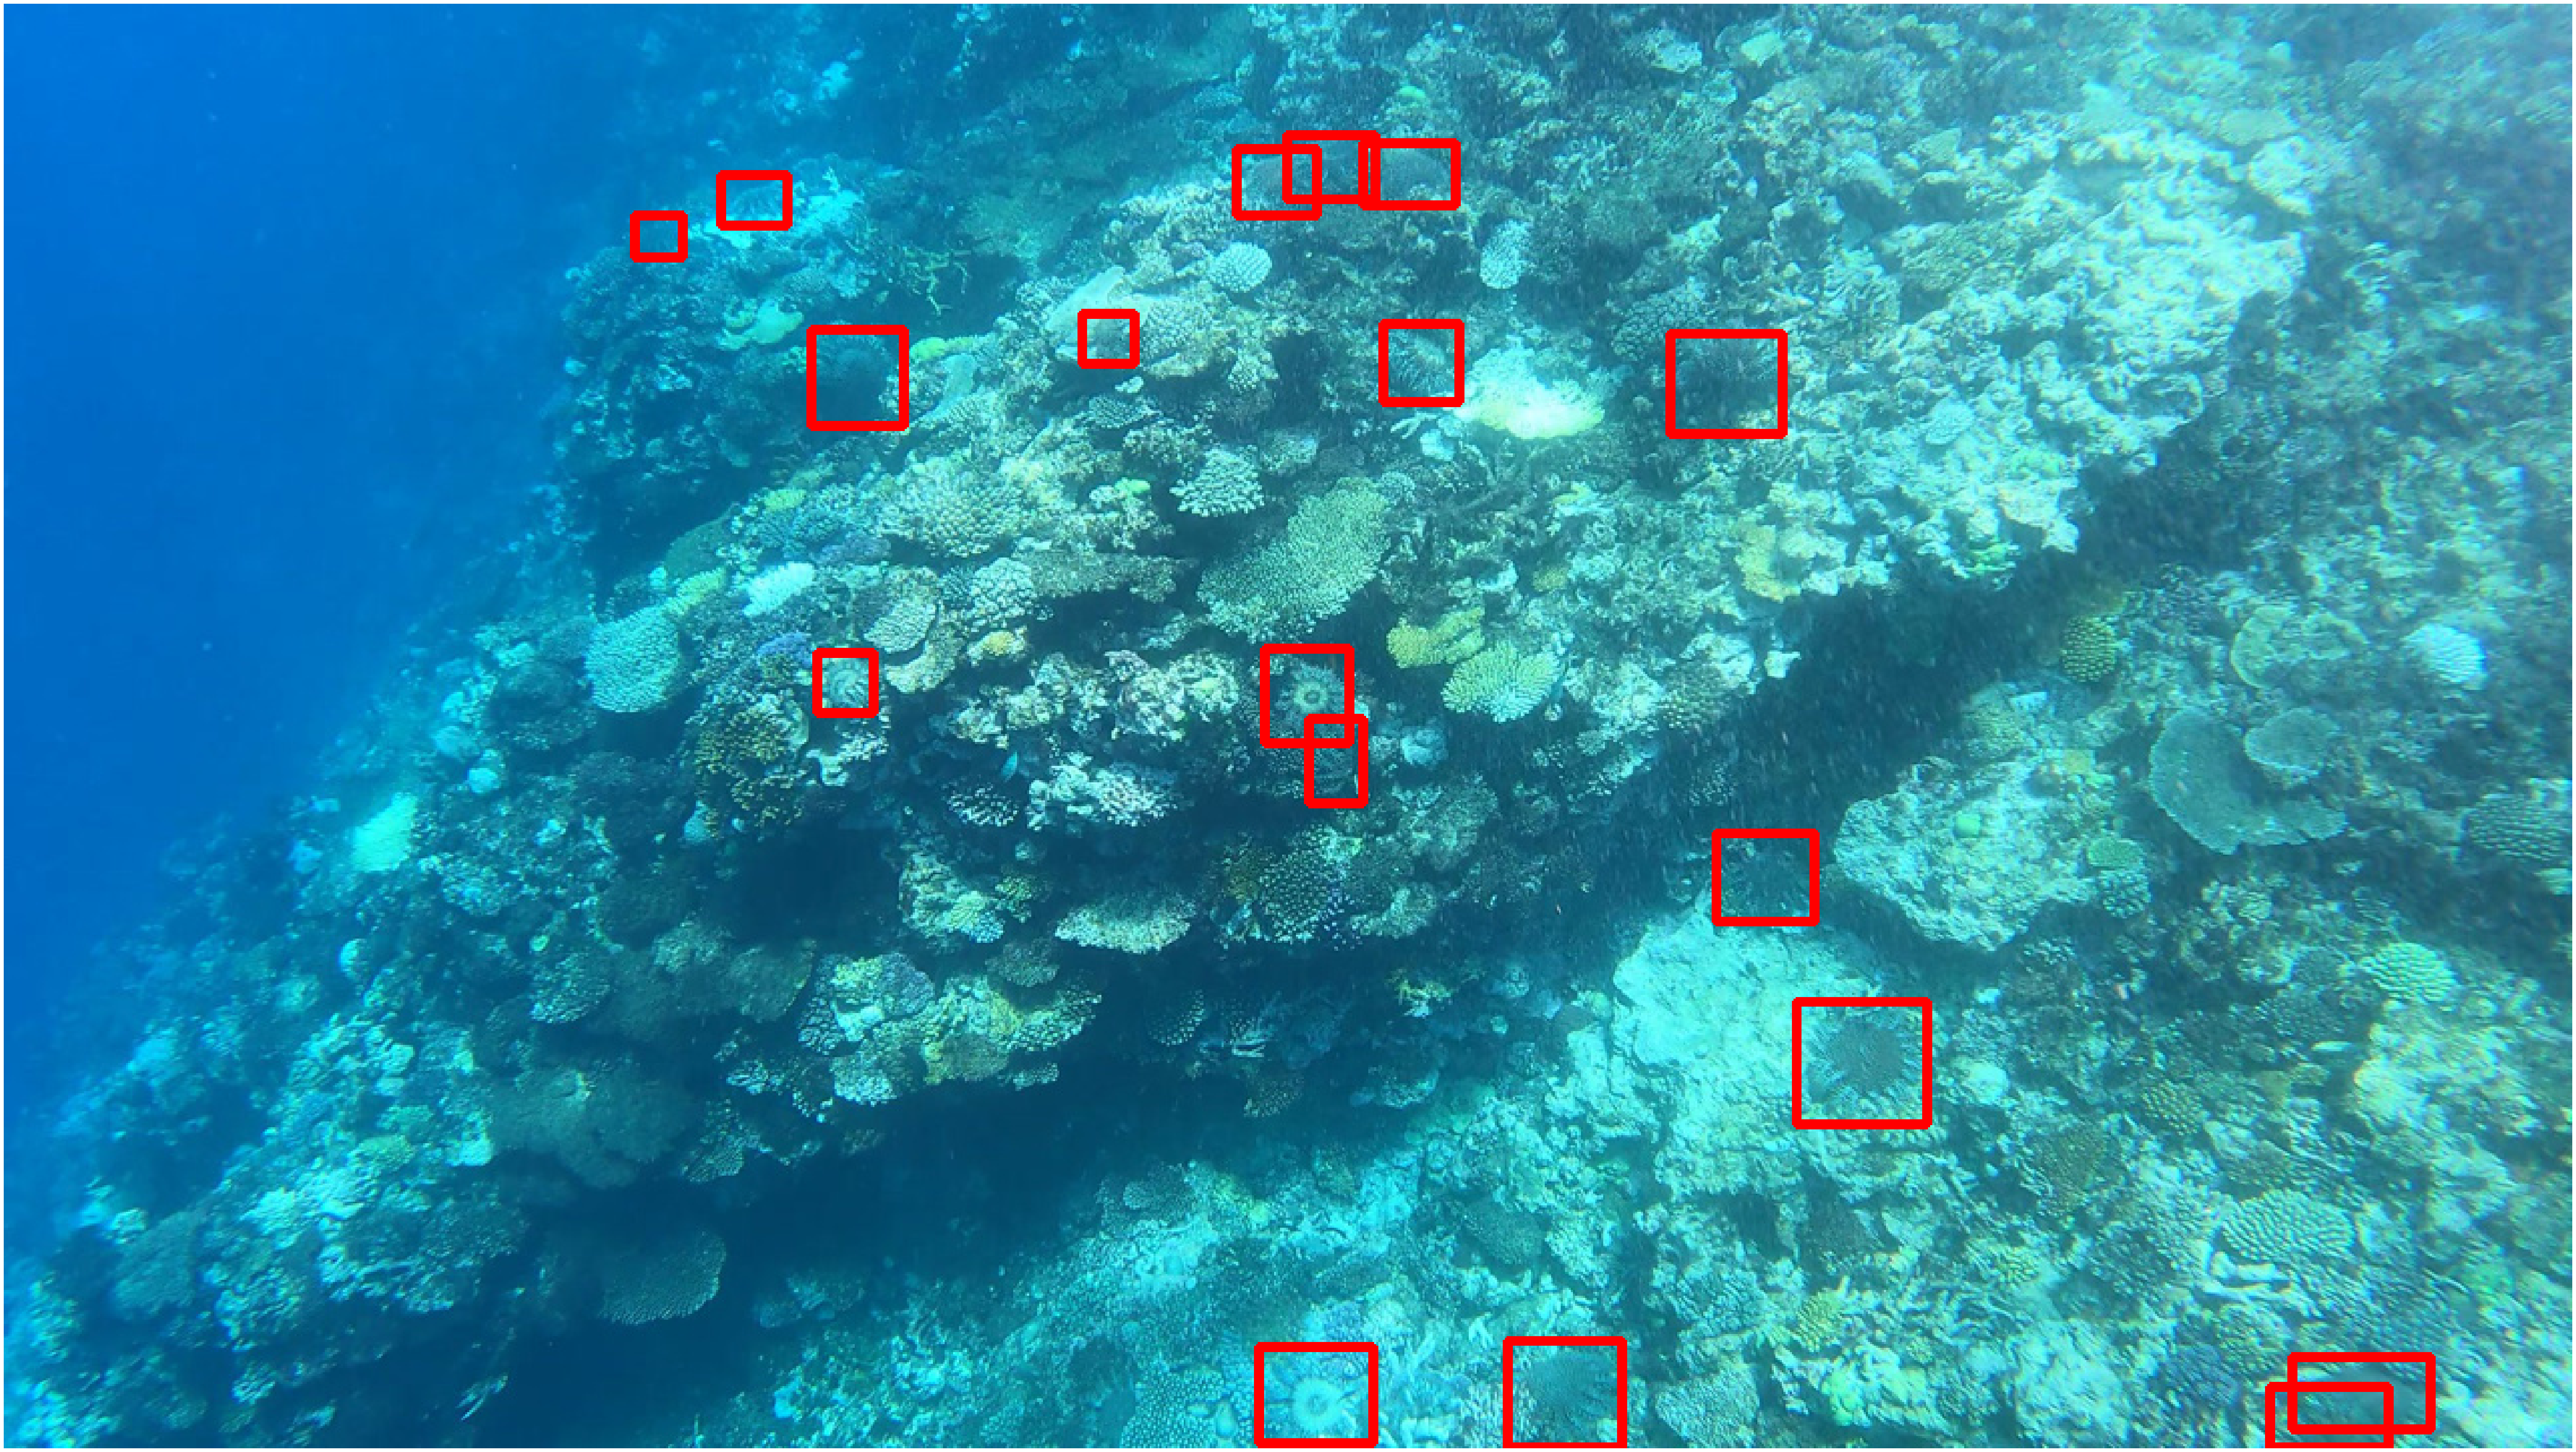

In [8]:
# EDA
df_max_bboxes = train_df_positive[train_df_positive['a_count'] == max(train_df_positive['a_count'])]
image_path = df_max_bboxes['img_path'].iloc[0] 
img_id = df_max_bboxes['image_id'].iloc[0]

img = imread(image_path).astype(np.int32)
df_gt_bboxes = test_ds.df_bbox[test_ds.df_bbox.image_id == img_id]
data = df_gt_bboxes[['x','y','width','height']].values
data[:,[2]] += data[:,[0]]
data[:,[3]] += data[:,[1]]
boxes = data.astype(np.uint32).tolist()

fig, ax = plt.subplots(1, 1, figsize=(100, 50))
# Red for ground truth
for box in boxes:
    cv2.rectangle(img,(box[0], box[1]),(box[2], box[3]),(255, 0, 0), 3)

ax.set_axis_off()
ax.imshow(img)

In [9]:
# calculate mean and std for cots dataset 
'''
sum_pixel = torch.tensor([0.0, 0.0, 0.0]).to(device)
sum_sq = torch.tensor([0.0, 0.0, 0.0]).to(device)

# loop through images
for batch_idx, (images, targets) in enumerate(train_loader, 1):
    inputs = torch.stack(list(images), dim=0)
    sum_pixel += inputs.sum(axis = [0, 2, 3])
    sum_sq += (inputs ** 2).sum(axis = [0, 2, 3])
    
count = len(train_ds) * 1280 * 720

# mean and std
total_mean = sum_pixel / count
total_var = (sum_sq / count) - (total_mean ** 2)
total_std = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

dict = {'total_mean': total_mean.cpu().tolist(), 'total_std': total_std.cpu().tolist()}  
df = pd.DataFrame(dict) 
df.to_csv(base_dir + '/train_models/cots_mean_std.csv') 
'''

"\nsum_pixel = torch.tensor([0.0, 0.0, 0.0]).to(device)\nsum_sq = torch.tensor([0.0, 0.0, 0.0]).to(device)\n\n# loop through images\nfor batch_idx, (images, targets) in enumerate(train_loader, 1):\n    inputs = torch.stack(list(images), dim=0)\n    sum_pixel += inputs.sum(axis = [0, 2, 3])\n    sum_sq += (inputs ** 2).sum(axis = [0, 2, 3])\n    \ncount = len(train_ds) * 1280 * 720\n\n# mean and std\ntotal_mean = sum_pixel / count\ntotal_var = (sum_sq / count) - (total_mean ** 2)\ntotal_std = torch.sqrt(total_var)\n\n# output\nprint('mean: '  + str(total_mean))\nprint('std:  '  + str(total_std))\n\ndict = {'total_mean': total_mean.cpu().tolist(), 'total_std': total_std.cpu().tolist()}  \ndf = pd.DataFrame(dict) \ndf.to_csv(base_dir + '/train_models/cots_mean_std.csv') \n"

In [10]:
#%cd train_models

from torchvision.models.detection.anchor_utils import AnchorGenerator
num_classes = 2
min_size = 810
max_size = 1440
df = pd.read_csv(base_dir + '/train_models/cots_mean_std.csv', header=0)
image_mean = df['total_mean'].tolist()
image_std = df['total_std'].tolist()

anchor_sizes = ((8,), (16,), (32,), (64,), (128,))
aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)

model = retinanet_resnet50_fpn_v2(weights=RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1, 
                                  rpn_anchor_generator=anchor_generator)  #image_mean=image_mean, image_std =image_std, 

# replace classification layer 
out_channels = model.head.classification_head.conv[0].out_channels
num_anchors = model.head.classification_head.num_anchors
model.head.classification_head.num_classes = num_classes

cls_logits = torch.nn.Conv2d(out_channels, num_anchors * num_classes, kernel_size = 3, stride=1, padding=1)
torch.nn.init.normal_(cls_logits.weight, std=0.01)  # as per pytorch code
torch.nn.init.constant_(cls_logits.bias, -math.log((1 - 0.01) / 0.01))  # as per pytorcch code 
# assign cls head to model
model.head.classification_head.cls_logits = cls_logits

no_of_epochs = 12

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(model.parameters(), lr=0.001,momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
model.to(DEVICE)
#summary(model, input_size=(1, 3, 720, 1280))

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth" to C:\Users\sl4n21/.cache\torch\hub\checkpoints\retinanet_resnet50_fpn_v2_coco-5905b1c5.pth


  0%|          | 0.00/146M [00:00<?, ?B/s]

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [11]:
time_start = datetime.now()
loss = []
loss_box_reg = []
loss_classifier = []
lr = []

loss_val = []
loss_box_reg_val = []
loss_classifier_val = []

n_batches, n_batches_val = len(train_loader), len(test_loader)

for epoch in range(no_of_epochs):
    time_begin = time.time()
    loss_accum = 0
    loss_reg_accum = 0 
    loss_cls_accum = 0 
    val_loss_accum = 0 
    val_loss_reg_accum = 0
    val_loss_cls_accum = 0 
    
    for batch_idx, (images, targets) in enumerate(train_loader, 1):
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        # Predict
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_reg = loss_dict['bbox_regression'].item()
        loss_cls = loss_dict['classification'].item()
        loss_accum += losses.item()
        loss_reg_accum += loss_reg
        loss_cls_accum += loss_cls
        # Back-prop
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        lr_epoch = lr_scheduler.get_last_lr()[0]

    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
        
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(test_loader, 1):
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            
            val_loss_dict = model(images, targets)
            val_batch_loss = sum(loss for loss in val_loss_dict.values()).item()
            val_loss_reg = val_loss_dict['bbox_regression'].item()
            val_loss_cls = val_loss_dict['classification'].item()
            val_loss_accum += val_batch_loss
            val_loss_reg_accum += val_loss_reg
            val_loss_cls_accum += val_loss_cls
    
    train_loss = loss_accum / n_batches
    val_loss = val_loss_accum / n_batches_val
    loss.append(train_loss)
    loss_val.append(val_loss)
    lr.append(lr_epoch)
    
    loss_box_reg.append(loss_reg_accum/n_batches)
    loss_classifier.append(loss_cls_accum/n_batches)
    loss_box_reg_val.append(val_loss_reg_accum/n_batches_val)
    loss_classifier_val.append(val_loss_cls_accum/n_batches_val)
    
    # Save model
    chk_name = f'./RetinaNet/retinanet_resnet50_fpn_anchor_{epoch+1}.bin'
    torch.save(model.state_dict(), chk_name)
    
    elapsed = time.time() - time_begin
    dict_01 = {'Epoch': epoch+1, 'no_of_epochs': no_of_epochs, 
               'train_loss': train_loss, 'val_loss': val_loss, 
               'chk_name': chk_name, 'time_used': elapsed}
    print('Epoch {Epoch: 2d}/{no_of_epochs:2d}_Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f} --> {chk_name} time_used: {time_used:.2f} seconds'.format(**dict_01))

print('Training Completed and time used: ', datetime.now() - time_start)

Epoch  1/12_Train loss: 0.906, Val loss: 0.527 --> ./RetinaNet/retinanet_resnet50_fpn_anchor_1.bin time_used: 1251.76 seconds
Epoch  2/12_Train loss: 0.428, Val loss: 0.390 --> ./RetinaNet/retinanet_resnet50_fpn_anchor_2.bin time_used: 1203.02 seconds
Epoch  3/12_Train loss: 0.298, Val loss: 0.351 --> ./RetinaNet/retinanet_resnet50_fpn_anchor_3.bin time_used: 1163.62 seconds
Epoch  4/12_Train loss: 0.234, Val loss: 0.347 --> ./RetinaNet/retinanet_resnet50_fpn_anchor_4.bin time_used: 1164.99 seconds
Epoch  5/12_Train loss: 0.201, Val loss: 0.349 --> ./RetinaNet/retinanet_resnet50_fpn_anchor_5.bin time_used: 1163.67 seconds
Epoch  6/12_Train loss: 0.177, Val loss: 0.352 --> ./RetinaNet/retinanet_resnet50_fpn_anchor_6.bin time_used: 1166.72 seconds
Epoch  7/12_Train loss: 0.157, Val loss: 0.358 --> ./RetinaNet/retinanet_resnet50_fpn_anchor_7.bin time_used: 1166.06 seconds
Epoch  8/12_Train loss: 0.145, Val loss: 0.362 --> ./RetinaNet/retinanet_resnet50_fpn_anchor_8.bin time_used: 1160.77 

In [12]:
dict_01 = {'loss': loss, 'loss_box_reg': loss_box_reg, 'loss_classifier': loss_classifier, 
           'lr': lr,'loss_val': loss_val, 'loss_box_reg_val': loss_box_reg_val, 
           'loss_classifier_val': loss_classifier_val}
df_training_log = pd.DataFrame(dict_01)
df_training_log.to_csv('./RetinaNet/training_log_RetinaNet_anchor.csv', index=False)

In [13]:
df_training_log = pd.read_csv('./RetinaNet/training_log_RetinaNet_anchor.csv', header=0)

In [15]:
df_training_log

,loss,loss_box_reg,loss_classifier,lr,loss_val,loss_box_reg_val,loss_classifier_val
0,0.905602,0.296859,0.608743,0.001000,0.527118,0.271369,0.397493
1,0.428328,0.213403,0.214925,0.001000,0.390119,0.239019,0.222385
2,0.298080,0.181294,0.116786,0.001000,0.350681,0.201622,0.125929
3,0.234072,0.156986,0.077087,0.000500,0.346755,0.174297,0.092323
4,0.201288,0.142773,0.058515,0.000500,0.349080,0.153275,0.066746
5,0.176860,0.130181,0.046679,0.000500,0.352225,0.140651,0.049638
6,0.156925,0.118784,0.038141,0.000250,0.357654,0.125691,0.042818
7,0.144653,0.110977,0.033676,0.000250,0.362476,0.119635,0.037666
8,0.135043,0.104625,0.030419,0.000250,0.368907,0.113451,0.033603
9,0.127112,0.099540,0.027572,0.000125,0.373428,0.110177,0.031915


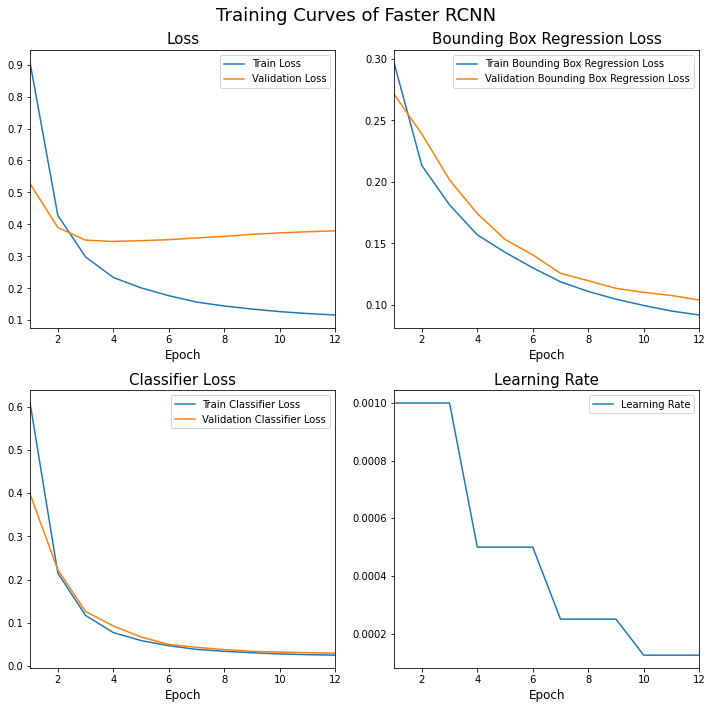

In [14]:
from matplotlib.ticker import MaxNLocator
epoch = np.arange(1,13,1)
fig, ax = plt.subplots(2,2,figsize=(10, 10))
ax[0, 0].set_xlim(1, 12)
ax[0, 0].plot(epoch, df_training_log['loss'], label='Train Loss')
ax[0, 0].plot(epoch, df_training_log['loss_val'], label='Validation Loss')
ax[0, 0].set_title('Loss', fontsize=15)
ax[0, 0].set_xlabel('Epoch', fontsize=12)
ax[0, 0].legend()

ax[0, 1].set_xlim(1, 12)
ax[0, 1].plot(epoch, df_training_log['loss_box_reg'], label='Train Bounding Box Regression Loss')
ax[0, 1].plot(epoch, df_training_log['loss_box_reg_val'], label='Validation Bounding Box Regression Loss')
ax[0, 1].set_title('Bounding Box Regression Loss', fontsize=15)
ax[0, 1].set_xlabel('Epoch', fontsize=12)
ax[0, 1].legend()

ax[1, 0].set_xlim(1, 12)
ax[1, 0].plot(epoch, df_training_log['loss_classifier'], label='Train Classifier Loss')
ax[1, 0].plot(epoch, df_training_log['loss_classifier_val'], label='Validation Classifier Loss')
ax[1, 0].set_title('Classifier Loss', fontsize=15)
ax[1, 0].set_xlabel('Epoch', fontsize=12)
ax[1, 0].legend()

ax[1, 1].set_xlim(1, 12)
ax[1, 1].plot(epoch, df_training_log['lr'], label='Learning Rate')
ax[1, 1].set_title('Learning Rate', fontsize=15)
ax[1, 1].set_xlabel('Epoch', fontsize=12)
ax[1, 1].legend()
fig.suptitle('Training Curves of Faster RCNN', fontsize=18)
fig.tight_layout()